# Pneumothorax Classification using OpenCV Histogram Comparison

This notebook implements a leave-one-out validation approach to evaluate four different histogram comparison methods in OpenCV for classifying chest X-ray images as either containing pneumothorax (positive class) or not (negative class).

Methods evaluated:
- CV_COMP_CORREL (Correlation)
- CV_COMP_CHISQR (Chi-Square)
- CV_COMP_INTERSECT (Intersection)
- CV_COMP_BHATTACHARYYA (Bhattacharyya distance)

For each method, we'll calculate:
- Confusion matrix
- Sensitivity (recall for positive class)
- Specificity (true negative rate)

In [220]:
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom

## 1. Data Preparation

load the labels file and prepare dataset.

In [221]:
labels_df = pd.read_csv('labels.csv')
print(f"Total images in dataset: {len(labels_df)}")

labels_df.head()

Total images in dataset: 250


,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


Class distribution:
label
No Pneumothorax    175
Pneumothorax        75
Name: count, dtype: int64


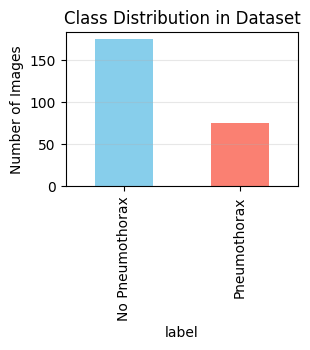

In [222]:
# Count the distribution of classes
class_counts = labels_df['label'].value_counts()
print("Class distribution:")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(3, 2))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution in Dataset')
plt.ylabel('Number of Images')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [223]:
# Get the first 15 files from each class
pneumothorax_files = labels_df[labels_df['label'] == 'Pneumothorax']['file'].tolist()[:15]
no_pneumothorax_files = labels_df[labels_df['label'] == 'No Pneumothorax']['file'].tolist()[:15]

print(f"Number of Pneumothorax files selected: {len(pneumothorax_files)}")
print(f"Number of No Pneumothorax files selected: {len(no_pneumothorax_files)}")

# Combine both lists
all_files = pneumothorax_files + no_pneumothorax_files
all_labels = ['Pneumothorax'] * 15 + ['No Pneumothorax'] * 15

Number of Pneumothorax files selected: 15
Number of No Pneumothorax files selected: 15


## 2. Image Processing Functions

Define functions to load DICOM images and extract histogram features.

In [224]:
# Define the path to the dataset root
DATASET_ROOT = "./"  # Path where your DICOM files are stored

def load_image(file_path):
    try:
        # Construct the full path to the DICOM file
        full_path = os.path.join(DATASET_ROOT, file_path)

        # Read the DICOM file
        dicom = pydicom.dcmread(full_path)

        # Convert to numpy array
        image = dicom.pixel_array

        # Normalize to 8-bit range
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        return image
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Function to extract features (histogram) from an image
def extract_features(image):
    # Calculate histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()

    return hist

## 3. Define Comparison Methods

Set up the OpenCV comparison methods we'll be evaluating.

In [225]:
# Define comparison methods
comparison_methods = {
    'cv2.HISTCMP_CORREL': cv2.HISTCMP_CORREL,           # Correlation
    'cv2.HISTCMP_CHISQR': cv2.HISTCMP_CHISQR,           # Chi-Square
    'cv2.HISTCMP_INTERSECT': cv2.HISTCMP_INTERSECT,     # Intersection
    'cv2.HISTCMP_BHATTACHARYYA': cv2.HISTCMP_BHATTACHARYYA  # Bhattacharyya distance
}

## 4. Classification Function

Implement the leave-one-out classification approach.

In [226]:
# Function to classify an image using leave-one-out approach with k-nearest neighbors
def classify_leave_one_out(test_idx, method_code, k=3):
    """Classify a test image using the k-nearest neighbors approach.

    Args:
        test_idx: Index of the test image in all_files list
        method_code: OpenCV histogram comparison method code
        k: Number of nearest neighbors to consider (default=3)

    Returns:
        Tuple of (true_label, predicted_label)
    """
    test_file = all_files[test_idx]
    test_label = all_labels[test_idx]

    # Load and extract features for test image
    test_image = load_image(test_file)
    test_hist = extract_features(test_image)

    # Store scores and labels
    scores = []

    # Compare with all other images
    for i, file_path in enumerate(all_files):
        if i == test_idx:
            continue # Skip the test image

        # Load and extract features for training image
        train_image = load_image(file_path)
        train_hist = extract_features(train_image)

        # Compare histograms
        score = cv2.compareHist(test_hist, train_hist, method_code)
        scores.append((score, all_labels[i]))

    # Sort scores based on comparison method
    if method_code in [cv2.HISTCMP_CORREL, cv2.HISTCMP_INTERSECT]:  # Higher is better
        scores.sort(reverse=True)  # Sort in descending order
    else:  # HISTCMP_CHISQR and HISTCMP_BHATTACHARYYA: Lower is better
        scores.sort()  # Sort in ascending order

    # Get the top k neighbors
    top_k = scores[:k]

    # Count votes for each class
    votes = {}
    for _, label in top_k:
        votes[label] = votes.get(label, 0) + 1

    # Get the majority vote
    pred_label = max(votes.items(), key=lambda x: x[1])[0]

    return test_label, pred_label

## 5. Evaluate Methods

Perform leave-one-out validation for each comparison method and calculate metrics.

In [227]:
# Results container
results = {}

# Function to run evaluation for a single method
def evaluate_method(method_name, method_code, k=3):
    """Evaluate a single comparison method."""
    print(f"\nEvaluating method: {method_name} with k={k}")

    true_labels = []
    pred_labels = []

    for i in range(len(all_files)):
        true_label, pred_label = classify_leave_one_out(i, method_code, k)
        true_labels.append(true_label)
        pred_labels.append(pred_label)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=['Pneumothorax', 'No Pneumothorax'])

    # Calculate sensitivity (recall for positive class - Pneumothorax)
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    # Calculate specificity (true negative rate - correctly identified No Pneumothorax)
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

    print(f"Confusion Matrix:\n{cm}")
    print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
    print(f"Specificity (True Negative Rate): {specificity:.4f}")

    # Get classification report
    report = classification_report(true_labels, pred_labels,
                                  target_names=['Pneumothorax', 'No Pneumothorax'])
    print(f"Classification Report:\n{report}")

    # Store results
    return {
        'confusion_matrix': cm,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'true_labels': true_labels,
        'pred_labels': pred_labels
    }

In [228]:
# Evaluate each method
for method_name, method_code in comparison_methods.items():
    results[method_name] = evaluate_method(method_name, method_code, k=11)


Evaluating method: cv2.HISTCMP_CORREL with k=11


Confusion Matrix:
[[10  5]
 [ 8  7]]
Sensitivity (True Positive Rate): 0.6667
Specificity (True Negative Rate): 0.4667
Classification Report:
                 precision    recall  f1-score   support

   Pneumothorax       0.58      0.47      0.52        15
No Pneumothorax       0.56      0.67      0.61        15

       accuracy                           0.57        30
      macro avg       0.57      0.57      0.56        30
   weighted avg       0.57      0.57      0.56        30


Evaluating method: cv2.HISTCMP_CHISQR with k=11
Confusion Matrix:
[[12  3]
 [12  3]]
Sensitivity (True Positive Rate): 0.8000
Specificity (True Negative Rate): 0.2000
Classification Report:
                 precision    recall  f1-score   support

   Pneumothorax       0.50      0.20      0.29        15
No Pneumothorax       0.50      0.80      0.62        15

       accuracy                           0.50        30
      macro avg       0.50      0.50      0.45        30
   weighted avg       0.50      0.5

## 6. Visualize Results

Create confusion matrices and summary tables for each method.

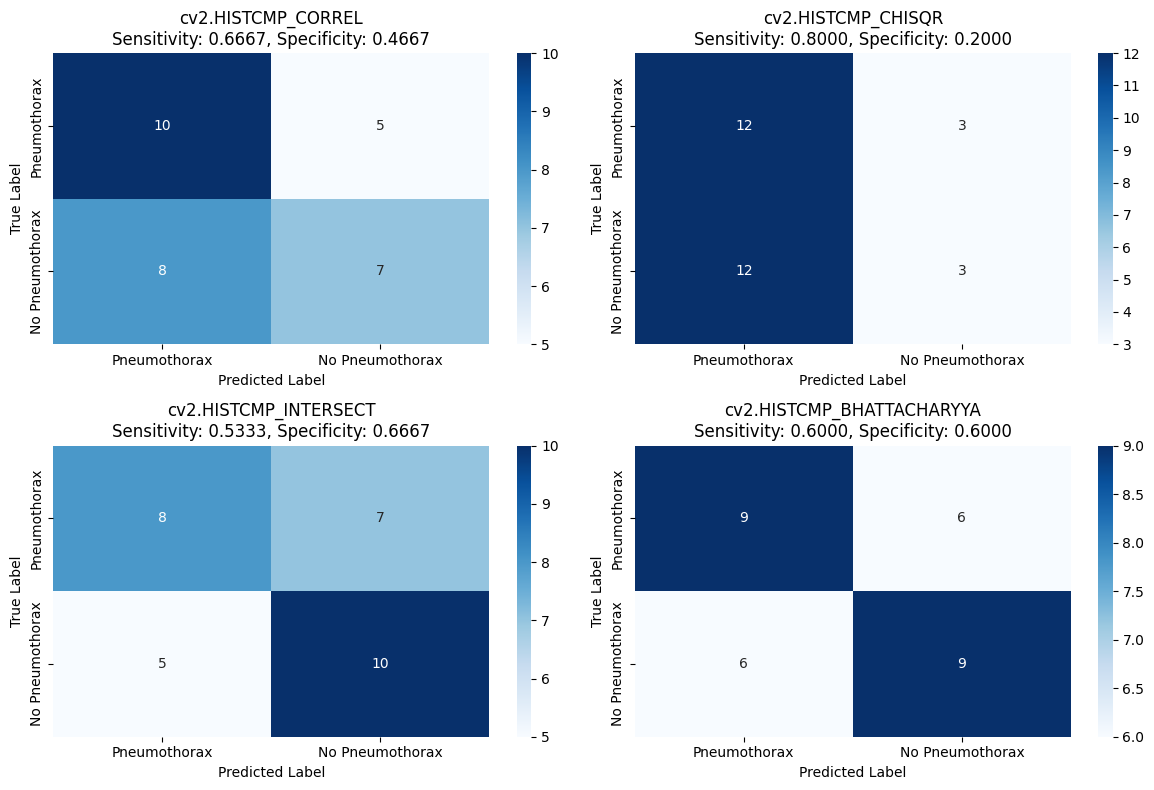

In [229]:
# Visualize confusion matrices
plt.figure(figsize=(12, 8))

for i, (method_name, result) in enumerate(results.items()):
    plt.subplot(2, 2, i+1)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pneumothorax', 'No Pneumothorax'],
                yticklabels=['Pneumothorax', 'No Pneumothorax'])
    plt.title(f"{method_name}\nSensitivity: {result['sensitivity']:.4f}, Specificity: {result['specificity']:.4f}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

In [230]:
# Create summary table
summary = pd.DataFrame({
    'Method': list(results.keys()),
    'Sensitivity': [results[m]['sensitivity'] for m in results],
    'Specificity': [results[m]['specificity'] for m in results]
})

print("\nSummary of Results:")
summary


Summary of Results:


,Method,Sensitivity,Specificity
0,cv2.HISTCMP_CORREL,0.666667,0.466667
1,cv2.HISTCMP_CHISQR,0.800000,0.200000
2,cv2.HISTCMP_INTERSECT,0.533333,0.666667
3,cv2.HISTCMP_BHATTACHARYYA,0.600000,0.600000


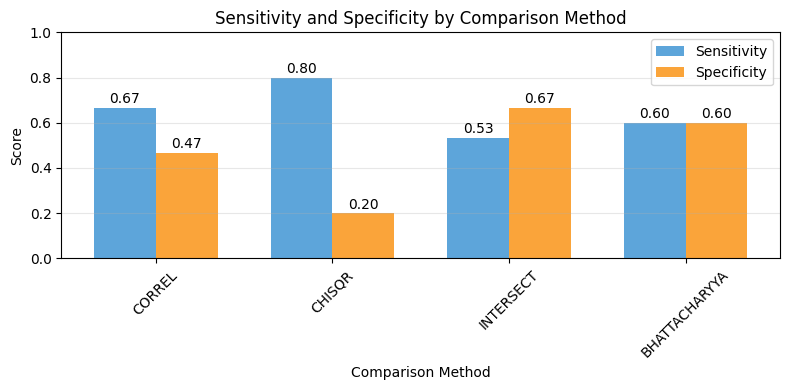

In [231]:
# Plot sensitivity and specificity for each method
plt.figure(figsize=(8, 4))

# Prepare data for grouped bar chart
methods = list(results.keys())
sensitivities = [results[m]['sensitivity'] for m in methods]
specificities = [results[m]['specificity'] for m in methods]

# Set bar positions
x = np.arange(len(methods))
width = 0.35

# Create bars
plt.bar(x - width/2, sensitivities, width, label='Sensitivity', color='#5DA5DA')
plt.bar(x + width/2, specificities, width, label='Specificity', color='#FAA43A')

# Add labels and legend
plt.xlabel('Comparison Method')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity by Comparison Method')
plt.xticks(x, [m.replace('cv2.HISTCMP_', '') for m in methods], rotation=45)
plt.legend()
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)

# Add value labels on the bars
for i, v in enumerate(sensitivities):
    plt.text(i - width/2, v + 0.02, f'{v:.2f}', ha='center')

for i, v in enumerate(specificities):
    plt.text(i + width/2, v + 0.02, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.savefig('sensitivity_specificity_comparison.png')
plt.show()

## 7. Conclusion

In this notebook, we evaluated four different histogram comparison methods for the task of pneumothorax classification in chest X-rays:

1. **Correlation (CV_COMP_CORREL)**: Measures similarity between histograms. Higher values indicate greater similarity.
2. **Chi-Square (CV_COMP_CHISQR)**: Measures statistical difference between histograms. Lower values indicate greater similarity.
3. **Intersection (CV_COMP_INTERSECT)**: Measures the common parts between histograms. Higher values indicate greater similarity.
4. **Bhattacharyya distance (CV_COMP_BHATTACHARYYA)**: Measures the similarity between probability distributions. Lower values indicate greater similarity.

The results show variations in performance across the methods, with different trade-offs between sensitivity (ability to detect pneumothorax cases) and specificity (ability to correctly identify non-pneumothorax cases).

This simple histogram-based approach demonstrates how traditional computer vision techniques can be applied to medical image classification. However, for real-world applications, more sophisticated methods like deep learning would likely yield better results.